<a href="https://colab.research.google.com/github/c-quilo/premiereDroplets/blob/main/PredictiveModel_Real%2BGenerated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Predictive model using experimental + synthetic data for droplet diameter size


In [50]:
from __future__ import print_function, division
import tensorflow.keras as tf
import tensorflow
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as backend
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras import backend
from keras.layers import Lambda
from keras.constraints import Constraint
from keras.initializers import RandomNormal

from keras import optimizers
from keras.utils import np_utils
import tensorflow.keras as tf
import pandas as pd
from scipy import io

In [64]:
nPredFeatures = 4

In [65]:
#filenameTraining = 'matTrainingDataSet_{}inputs.mat'.format(nPredFeatures)
#arrayTraining = scipy.io.loadmat(filenameTraining)

#data = arrayTraining['matTrainingDataSet']['inputs'][0][0]
#data_output = arrayTraining['matTrainingDataSet']['output'][0][0]

filenameGenerated = 'generated_data_{}features.npy'.format(nPredFeatures)
generated_data = np.load(filenameGenerated)

data = np.log(generated_data[:, :-1] + 1)
data_output = np.log(generated_data[:, -1] + 1)
#data = np.log(np.vstack((data, generated_data[:, :-1])) + 1)
#data_output = np.squeeze(np.log(np.vstack((data_output, np.expand_dims(generated_data[:, -1], 1))) + 1))

Predictive model (4 features --> Formation time)

Epoch 1/5000


KeyboardInterrupt: ignored

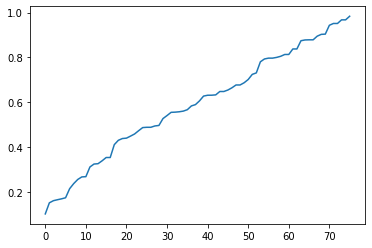

In [66]:
normOrStand = 'norm'

if normOrStand == 'norm':
  min_ls = np.min(data, 0)
  max_ls = np.max(data, 0)
  min_y = np.min(data_output, 0)
  max_y = np.max(data_output, 0)
  min_data = 0
  max_data = +1

  def scaler(x, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xScaled = scale * x + min - xmin * scale
    return xScaled

  data = scaler(data, min_ls, max_ls, min_data, max_data)
  data_output = scaler(data_output, min_y, max_y, min_data, max_data)

elif normOrStand == 'stand':
  meanData = np.mean(data, 0)
  stdData = np.std(data, 0)
  data = (data - meanData)/stdData

input_net = tf.Input(nPredFeatures)
net = tf.layers.Dense(1024)(input_net)
net = tf.layers.BatchNormalization()(net)
net = tf.layers.LeakyReLU()(net)
net = tf.layers.Dropout(0.5)(net)
net = tf.layers.Dense(1024)(net)
net = tf.layers.BatchNormalization()(net)
net = tf.layers.LeakyReLU()(net)
net = tf.layers.Dropout(0.5)(net)
output_net = tf.layers.Dense(1, activation='sigmoid')(net)

X_train, y_train, indices = data, data_output, range(data.shape[0])

filenameTest = 'matTestDataSet_{}inputs.mat'.format(nPredFeatures)
arrayTest = scipy.io.loadmat(filenameTest)
X_test = arrayTest['matTestDataSet']['inputs'][0][0]
#Transform nan values to 0
X_test[np.isnan(X_test)] = 0
X_test = scaler(np.log(X_test + 1), min_ls, max_ls, min_data, max_data)
y_test = scaler(np.squeeze(np.log(arrayTest['matTestDataSet']['output'][0][0] + 1)), min_y, max_y, min_data, max_data)

plt.plot(np.sort(np.squeeze(y_test)))

predictor = tf.Model(input_net, output_net, name='Predictor')
predictor.compile(loss='mse',
                  optimizer=tf.optimizers.Nadam())
batch_size = 512
epochs = 5000
predictor.fit(X_train, 
              y_train, 
              batch_size=batch_size,
              epochs=epochs, 
              validation_data=(X_test, y_test))

In [25]:
predicted_data =  np.squeeze(predictor.predict(X_test))
def inverseScaler(xscaled, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xInv = (xscaled/scale) - (min/scale) + xmin
    return xInv

if normOrStand == 'norm':
  predicted_data = inverseScaler(predicted_data, min_y, max_y, min_data, max_data)
  real_data = inverseScaler(y_test, min_y, max_y, min_data, max_data)
elif normOrStand == 'stand':
  predicted_data = predicted_data*stdData[3] + meanData[3]
  real_data = data.iloc[:, 3]*stdData[3] + meanData[3]

predicted_data = np.exp(predicted_data)
real_data = np.exp(real_data)

predicted_data = predicted_data - 1
real_data = real_data - 1

[0.6334549  0.6514803  0.66105986 0.6326711  0.6508889  0.70257556
 0.63073397 0.6394646  0.6260166  0.629269   0.6545416  0.6397188
 0.65380085 0.64199734 0.65484357 0.6392591  0.66368294 0.63324785
 0.6326047  0.63823783 0.6392311  0.6397699  0.66142166 0.64085627
 0.6383543  0.65928006 0.6348201  0.6562437  0.65818954 0.6538043
 0.638744   0.629269   0.6408794  0.64220226 0.6212938  0.65386224
 0.6308087  0.64037955 0.63653696 0.64947593 0.6366539  0.63471866
 0.6449766  0.6251755  0.6461085  0.64815676 0.65325594 0.63868606
 0.6511762  0.6395612  0.64037955 0.61792016 0.6400876  0.64037955
 0.6539371  0.6649312  0.64705074 0.63283443 0.66062415 0.626735
 0.6328901  0.6495857  0.65762854 0.6364436  0.6471126  0.62778795
 0.65232456 0.64290273 0.6563529  0.64124024 0.63147104 0.7019763
 0.6509036  0.66501474 0.6348227  0.63685536]
[0.14901701 0.188      0.1263     0.10486422 0.1113     0.161
 0.144      0.1366     0.10013383 0.132      0.151      0.153
 0.1545     0.14854279 0.192   

76
[[0.81332468 0.22535926 0.12178871]
 [0.34829023 0.05194119 0.12862602]
 [0.62390709 0.67088332 0.01258618]
 ...
 [0.66517944 0.19486951 0.24566583]
 [0.2253506  0.04141479 0.4080732 ]
 [0.42109721 0.06398535 0.02738721]]
(76,)


<function matplotlib.pyplot.tight_layout>

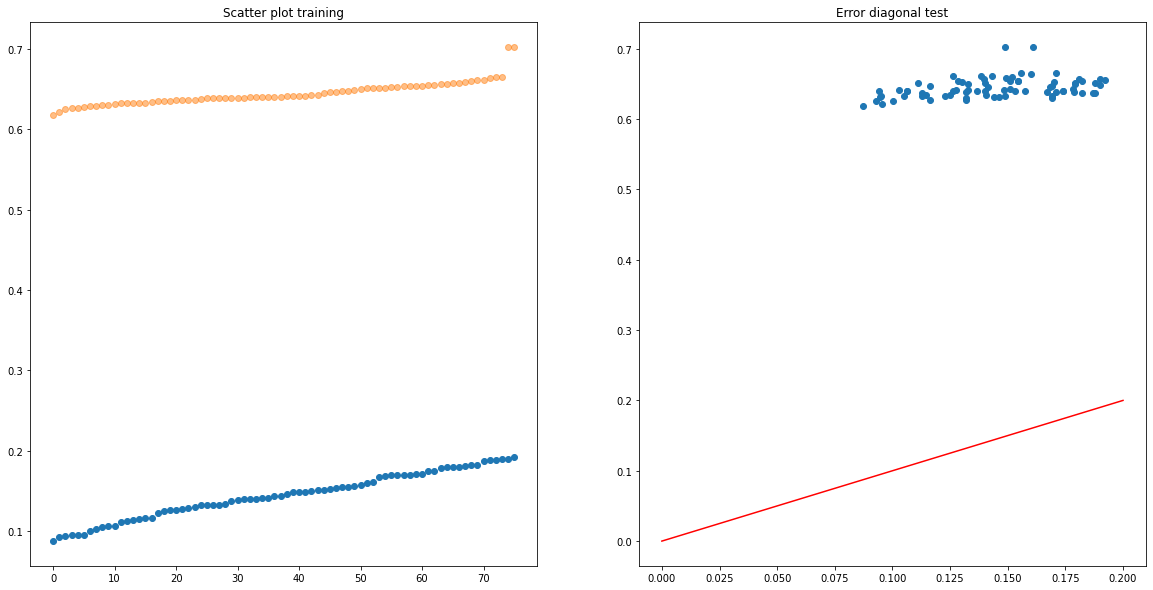

In [26]:
#Plots
fig = plt.figure(figsize=(20,10))
nPointsTrain = real_data.shape[0]
print(nPointsTrain)
print(data)
plt.subplot(1,2,1)
plt.scatter(range(nPointsTrain), np.sort(real_data))
plt.scatter(range(nPointsTrain), np.sort(predicted_data), alpha=0.5)
plt.title('Scatter plot training')
print(real_data.shape)
plt.subplot(1,2,2)
plt.scatter(real_data, predicted_data)
#plt.xlim(0,100)
#plt.ylim(0,100)
ident = [0.0, 0.2]
plt.plot(ident,ident, color='r')
plt.title('Error diagonal test')
plt.tight_layout

In [27]:
#Error
#MAPE
MAPE = np.mean(np.abs(np.squeeze(real_data) - np.squeeze(predicted_data))/np.squeeze(real_data))
print(MAPE)
threshold = 100

temp1 = real_data[np.where(real_data<threshold)[0]]
temp2 = predicted_data[np.where(real_data<threshold)[0]]
MAPE_threshold = np.mean(np.abs(np.squeeze(temp1) - np.squeeze(temp2))/np.squeeze(temp1))
print(MAPE_threshold)

3.654212044714201
3.654212044714201


In [28]:
#@markdown Prediction with XGBoost

[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

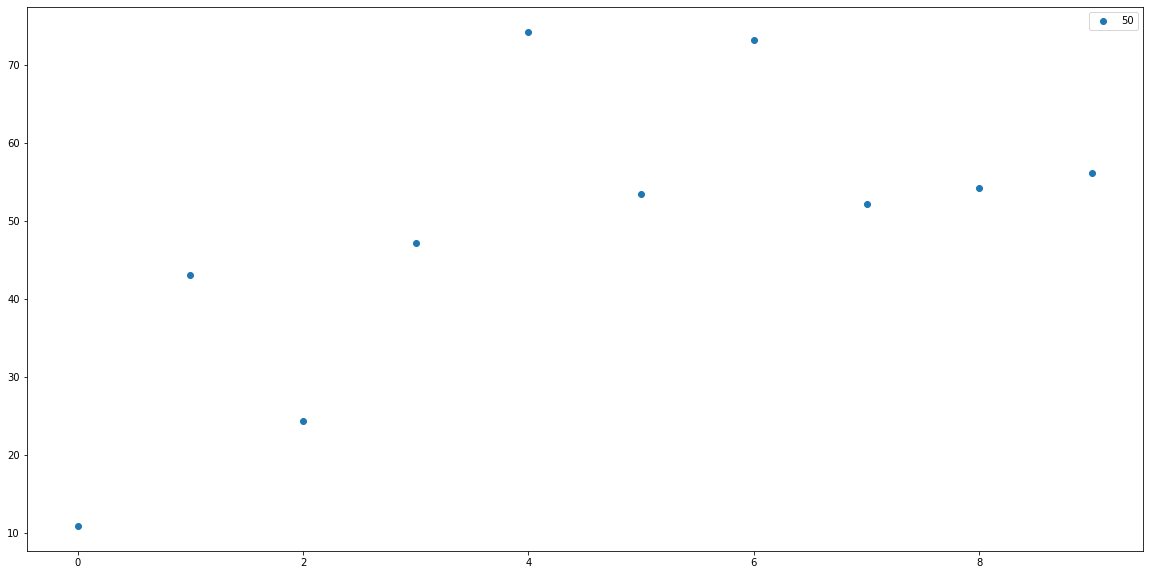

In [53]:
import random
import xgboost as xgb

reg = xgb.XGBRegressor(random_state=42)
reg = xgb.XGBRegressor()
#reg = LazyRegressor(predictions=True)#, regressors = LazyRegressor.provide_models)

nSamples = [0]#10, 100, 200, 300, 392]
nSynthetics = [10, 25, 50, 100, 250, 500, 750, 1000, 5000, 10000]

MAPE_collect = np.zeros((1, 1, 10))

k = 0
for k in range(1):
  i = 0
  for nsample in nSamples:
    j = 0
    for nSynthetic in nSynthetics:

      generated_data = np.load('generated_data_{}features.npy'.format(nPredFeatures))

      randIndexExperimental = random.sample(range(10000), nSynthetic)

      if nSynthetic == 0:
        data = np.log(data[randIndexExperimental, :] + 1)
        data_output = np.squeeze(np.log(data_output[randIndexExperimental] + 1))
      else:
        data = np.log(generated_data[randIndexExperimental, :-1] + 1)
        data_output = np.log(generated_data[randIndexExperimental, -1] + 1)

      min_ls = np.min(data, 0)
      max_ls = np.max(data, 0)
      min_y = np.min(data_output, 0)
      max_y = np.max(data_output, 0)
      min_data = 0
      max_data = +1
      data = scaler(data, min_ls, max_ls, min_data, max_data)
      data_output = scaler(data_output, min_y, max_y, min_data, max_data)

      randIndex = random.sample(range(10392), nsample)
      model = xgb.XGBRegressor()
      model.fit(data, data_output)

      predicted_data = model.predict(X_test)

      def inverseScaler(xscaled, xmin, xmax, min, max):
          scale = (max - min) / (xmax - xmin)
          xInv = (xscaled/scale) - (min/scale) + xmin
          return xInv

      if normOrStand == 'norm':
        predicted_data = inverseScaler(predicted_data, min_y, max_y, min_data, max_data)
        real_data = inverseScaler(y_test, min_y, max_y, min_data, max_data)
      elif normOrStand == 'stand':
        predicted_data = predicted_data*stdData[3] + meanData[3]
        real_data = data.iloc[:, 3]*stdData[3] + meanData[3]

      predicted_data = np.exp(predicted_data)
      real_data = np.exp(real_data)
      D = 195e-3

      predicted_data = (predicted_data - 1)/D
      real_data = (real_data - 1)/D

      #MAPE
      MAPE = np.mean(np.abs(np.squeeze(real_data) - np.squeeze(predicted_data))/np.squeeze(real_data))
      threshold = 100
      fig = plt.figure(figsize=(20,10))
      nPointsTrain = real_data.shape[0]

      MAPE_collect[k, i, j] = MAPE
      j += 1
    i += 1
  print(k)
  k += 1

np.save('MAPE_collect', MAPE_collect[:, :])
plt.plot(range(10), np.squeeze(MAPE_collect[0, :, :])*100, 'o')
plt.legend(['50', '100', '250', '500', '750', '1000'])
#ax.set_xtickslabels(['0', '10', '100', '1000', '10000'])
print(MAPE_collect*100)

[11:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor()
0.05727297735509467
0.05727297735509467


Text(0.5, 0.98, 'Experimental, 4 features, XGBOOST, MAPE = 5.727%')

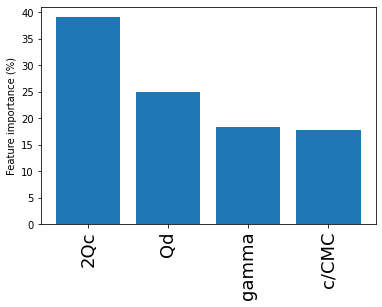

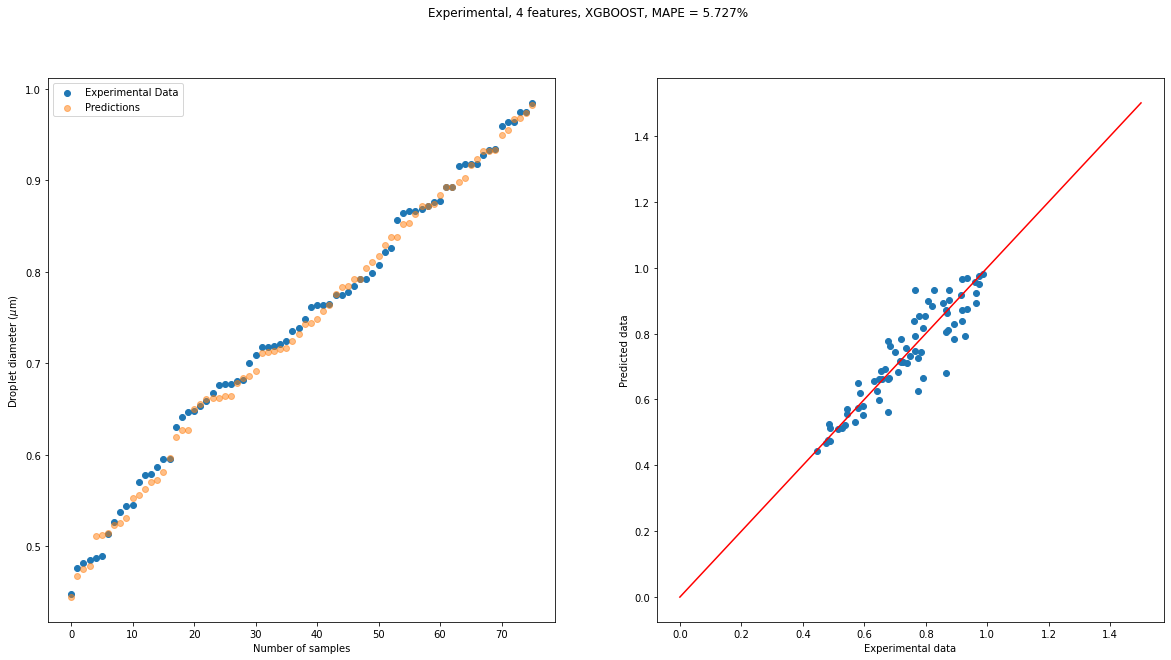

In [67]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
print(model)
model.predict(X_test)
fig, ax = plt.subplots(1,1) 

# Set number of ticks for x-axis
np.save('Feature_Importance_{}_ExpGen'.format(nPredFeatures), 100*model.feature_importances_)
ax.bar(range(nPredFeatures), 100*model.feature_importances_)
if nPredFeatures == 3:
  x_ticks_labels = ['2Qc', 'Qd', 'c/CMC']
elif nPredFeatures == 4:
  x_ticks_labels = ['2Qc', 'Qd', 'gamma', 'c/CMC']

ax.set_xticks(range(nPredFeatures))
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=18)
plt.ylabel('Feature importance (%)')
predicted_data = np.array(model.predict(X_test))
def inverseScaler(xscaled, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xInv = (xscaled/scale) - (min/scale) + xmin
    return xInv

if normOrStand == 'norm':
  predicted_data = inverseScaler(predicted_data, min_y, max_y, min_data, max_data)
  real_data = inverseScaler(y_test, min_y, max_y, min_data, max_data)
elif normOrStand == 'stand':
  predicted_data = predicted_data*stdData[3] + meanData[3]
  real_data = data.iloc[:, 3]*stdData[3] + meanData[3]

predicted_data = np.exp(predicted_data)
real_data = np.exp(real_data)
D = 195e-3

predicted_data = (predicted_data - 1)/D
real_data = (real_data - 1)/D
np.save('predictedData{}Features_ExpGen_with_100'.format(nPredFeatures), predicted_data)

#MAPE
MAPE = np.mean(np.abs(np.squeeze(real_data) - np.squeeze(predicted_data))/np.squeeze(real_data))
print(MAPE)
threshold = 100

temp1 = real_data[np.where(real_data<threshold)[0]]
temp2 = predicted_data[np.where(real_data<threshold)[0]]
MAPE_threshold = np.mean(np.abs(np.squeeze(temp1) - np.squeeze(temp2))/np.squeeze(temp1))
print(MAPE_threshold)

#Plots
fig = plt.figure(figsize=(20,10))
nPointsTrain = real_data.shape[0]

plt.subplot(1,2,1)
plt.scatter(range(nPointsTrain), np.sort(real_data))
plt.scatter(range(nPointsTrain), np.sort(predicted_data), alpha=0.5)
plt.xlabel('Number of samples')
plt.ylabel('Droplet diameter ($\mu$m)')
plt.legend(['Experimental Data', 'Predictions'])
plt.subplot(1,2,2)
plt.scatter(real_data, predicted_data)
#plt.xlim(0,100)
#plt.ylim(0,100)
ident = [0.0, 1.5]
plt.plot(ident,ident, color='r')
plt.xlabel('Experimental data')
plt.ylabel('Predicted data')
plt.tight_layout
plt.suptitle('Experimental, {} features, XGBOOST, MAPE = '.format(nPredFeatures) + '%.3f'%(MAPE*100) + '%')